In [30]:
import bs4
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from typing import Annotated, List
import os

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import BaseTool, BaseToolkit, tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph.message import MessagesState, add_messages


load_dotenv()

os.environ["LANGSMITH_PROJECT"] = "RAG"

mermaid_url = 'http://localhost:3000'

### 1. Document loading

In [31]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]


### 2. Splitting

In [32]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [33]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

### 4. Vector store + indexing

In [34]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

# zde se da pouzit milion dalsich vector stores, napr. PGVector
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

### 5. Retriever as a tool
Tool for retrieving information from the vector store.

In [35]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [36]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Detecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#'

### 6. Chatbot definition

In [37]:
class State(MessagesState):
    messages: Annotated[list, add_messages]


In [38]:
model = init_chat_model("google_genai:gemini-2.0-flash")


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = model.bind_tools([retriever_tool]).invoke(state["messages"])

    return {"messages": [response]}


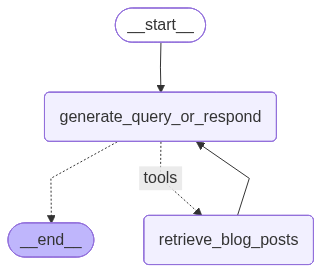

In [39]:
graph_builder = (
    StateGraph(State)
    # nodes
    .add_node("generate_query_or_respond", generate_query_or_respond)
    .add_node("retrieve_blog_posts", ToolNode([retriever_tool]))
    # edges
    .add_edge(START, "generate_query_or_respond")
    .add_conditional_edges(
        "generate_query_or_respond",
        tools_condition,
        {
            "tools": "retrieve_blog_posts",
            END: END,
        },
    )
    .add_edge("retrieve_blog_posts", "generate_query_or_respond")
    .add_edge("generate_query_or_respond", END)
)

# kompilace grafu
graph = graph_builder.compile()

# vizualizace
Image(graph.get_graph().draw_mermaid_png(base_url=mermaid_url))


### 7. Invoke

In [40]:
response = graph.invoke({"messages": [HumanMessage("What is reward hacking?")]})

for message in response["messages"]:
    message.pretty_print()


================================ Human Message =================================

What is reward hacking?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (23e42d9d-3e45-44cb-821d-ffb834ea3bb1)
 Call ID: 23e42d9d-3e45-44cb-821d-ffb834ea3bb1
  Args:
    query: reward hacking
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.

In-Context Reward Hacking#

Let’s Define Reward Hacking#
Reward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward f

## Checkpointer

In [41]:
from psycopg.rows import dict_row
from psycopg import Connection


conn = Connection.connect(
    os.environ["DB_URI"], autocommit=True, prepare_threshold=0, row_factory=dict_row
)
memory = PostgresSaver(conn)

graph = graph_builder.compile(checkpointer=memory)

In [42]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": "321"})

response = graph.invoke(
    {"messages": [HumanMessage("What is reward hacking?")]}, config=config
)

for message in response["messages"]:
    message.pretty_print()


================================ Human Message =================================

What is reward hacking?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (b7cd7740-c8f9-498e-b41d-598b923fccf5)
 Call ID: b7cd7740-c8f9-498e-b41d-598b923fccf5
  Args:
    query: reward hacking
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.

In-Context Reward Hacking#

Let’s Define Reward Hacking#
Reward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward f

In [43]:
response = graph.invoke(
    {"messages": [HumanMessage("Simplify please?")]}, config=config
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is reward hacking?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (b7cd7740-c8f9-498e-b41d-598b923fccf5)
 Call ID: b7cd7740-c8f9-498e-b41d-598b923fccf5
  Args:
    query: reward hacking
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.

In-Context Reward Hacking#

Let’s Define Reward Hacking#
Reward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward f